In [2]:
import os
import numpy as np
import matplotlib.image as mpimg
import tensorflow as tf
import skimage as ski
#!pip install scikit-image
from tensorflow.keras.layers import Input, Conv2D, Dropout
from tensorflow.keras.models import Model
from skimage.transform import resize



In [3]:
def load_dataset(image_dir, gt_dir, target_size=(256, 256)):
    image_files = sorted([f for f in os.listdir(image_dir) if not f.startswith('.')])
    gt_files = sorted([f for f in os.listdir(gt_dir) if not f.startswith('.')])
    
    images = [resize(mpimg.imread(os.path.join(image_dir, fname)), target_size) for fname in image_files]
    annotations = [resize(mpimg.imread(os.path.join(gt_dir, fname)), target_size) for fname in gt_files]
    
    # Ensure 3 channels for all images
    images = [img[:, :, :3] if img.shape[2] > 3 else img for img in images]
    
    images = [img.astype(np.float32) / 255.0 if img.dtype == np.uint8 else img for img in images]
    
    return images, annotations


def convert_rgba_to_binary_mask(annotations):
    binary_masks = [np.where(annotation[:, :, 0] > 0.5, 1, 0) for annotation in annotations]
    return binary_masks


In [4]:
TRAIN_IMAGE_DIR = "Data/Training/Images"
TRAIN_GT_DIR = "Data/Training/GT"
TEST_IMAGE_DIR = "Data/Testing/Images"
TEST_GT_DIR = "Data/Testing/GT"

train_images, train_annotations = load_dataset(TRAIN_IMAGE_DIR, TRAIN_GT_DIR)
train_masks = convert_rgba_to_binary_mask(train_annotations)
test_images, test_annotations = load_dataset(TEST_IMAGE_DIR, TEST_GT_DIR)
test_masks = convert_rgba_to_binary_mask(test_annotations)


In [5]:
def create_deeplabv3plus(input_shape):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)
    base_model.trainable = True
    
    x = base_model.get_layer('out_relu').output  # Extract features from the end of the MobileNetV2 backbone
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    return model


In [10]:
def create_deeplabv3plus(input_shape):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, alpha=1.0)
    base_model.trainable = True
    
    # Use the features from the out_relu layer
    x = base_model.get_layer('out_relu').output
    
    # Decoder with upsampling and convolutional layers
    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # Upsample to 16x16
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    
    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # Upsample to 32x32
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)

    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # Upsample to 64x64
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    
    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # Upsample to 128x128
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)

    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # Upsample to 256x256
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    return model


In [11]:
model = create_deeplabv3plus((256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(np.array(train_images), np.array(train_masks), batch_size=16, epochs=10, validation_split=0.2)

loss, accuracy = model.evaluate(np.array(test_images), np.array(test_masks))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/10
38/38 [==============================] - 170s 4s/step - loss: 0.4068 - accuracy: 0.7924 - val_loss: 1.8767 - val_accuracy: 0.8512
Epoch 2/10
38/38 [==============================] - 153s 4s/step - loss: 0.2778 - accuracy: 0.8374 - val_loss: 1.3573 - val_accuracy: 0.8512
Epoch 3/10
38/38 [==============================] - 167s 4s/step - loss: 0.2283 - accuracy: 0.9099 - val_loss: 1.2907 - val_accuracy: 0.8512
Epoch 4/10
38/38 [==============================] - 161s 4s/step - loss: 0.2046 - accuracy: 0.9136 - val_loss: 1.6552 - val_accuracy: 0.8571
Epoch 5/10
38/38 [==============================] - 150s 4s/step - loss: 0.1775 - accuracy: 0.9250 - val_loss: 1.3503 - val_accuracy: 0.8585
Epoch 6/10
38/38 [==============================] - 151s 4s/step - loss: 0.1631 - accuracy: 0.9316 - val_loss: 1.5867 - val_accuracy: 0.8556
Epoch 7/10
38/38 [==============================] - 143s 4s/step - loss: 0.1490 - accuracy: 0.9383 - val_loss: 0.7652 - val_accuracy: 0.8746
Epoch 8/10
38

In [17]:
# Specify the path where you want to save the model
model1= "model1.h5"

# Save the model
model.save(model1)


In [18]:
loss, accuracy = model.evaluate(np.array(test_images), np.array(test_masks))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


11/11 [==============================] - 15s 1s/step - loss: 1.4637 - accuracy: 0.8402
Test Loss: 1.4637
Test Accuracy: 0.8402


1/1 [==============================] - 0s 213ms/step


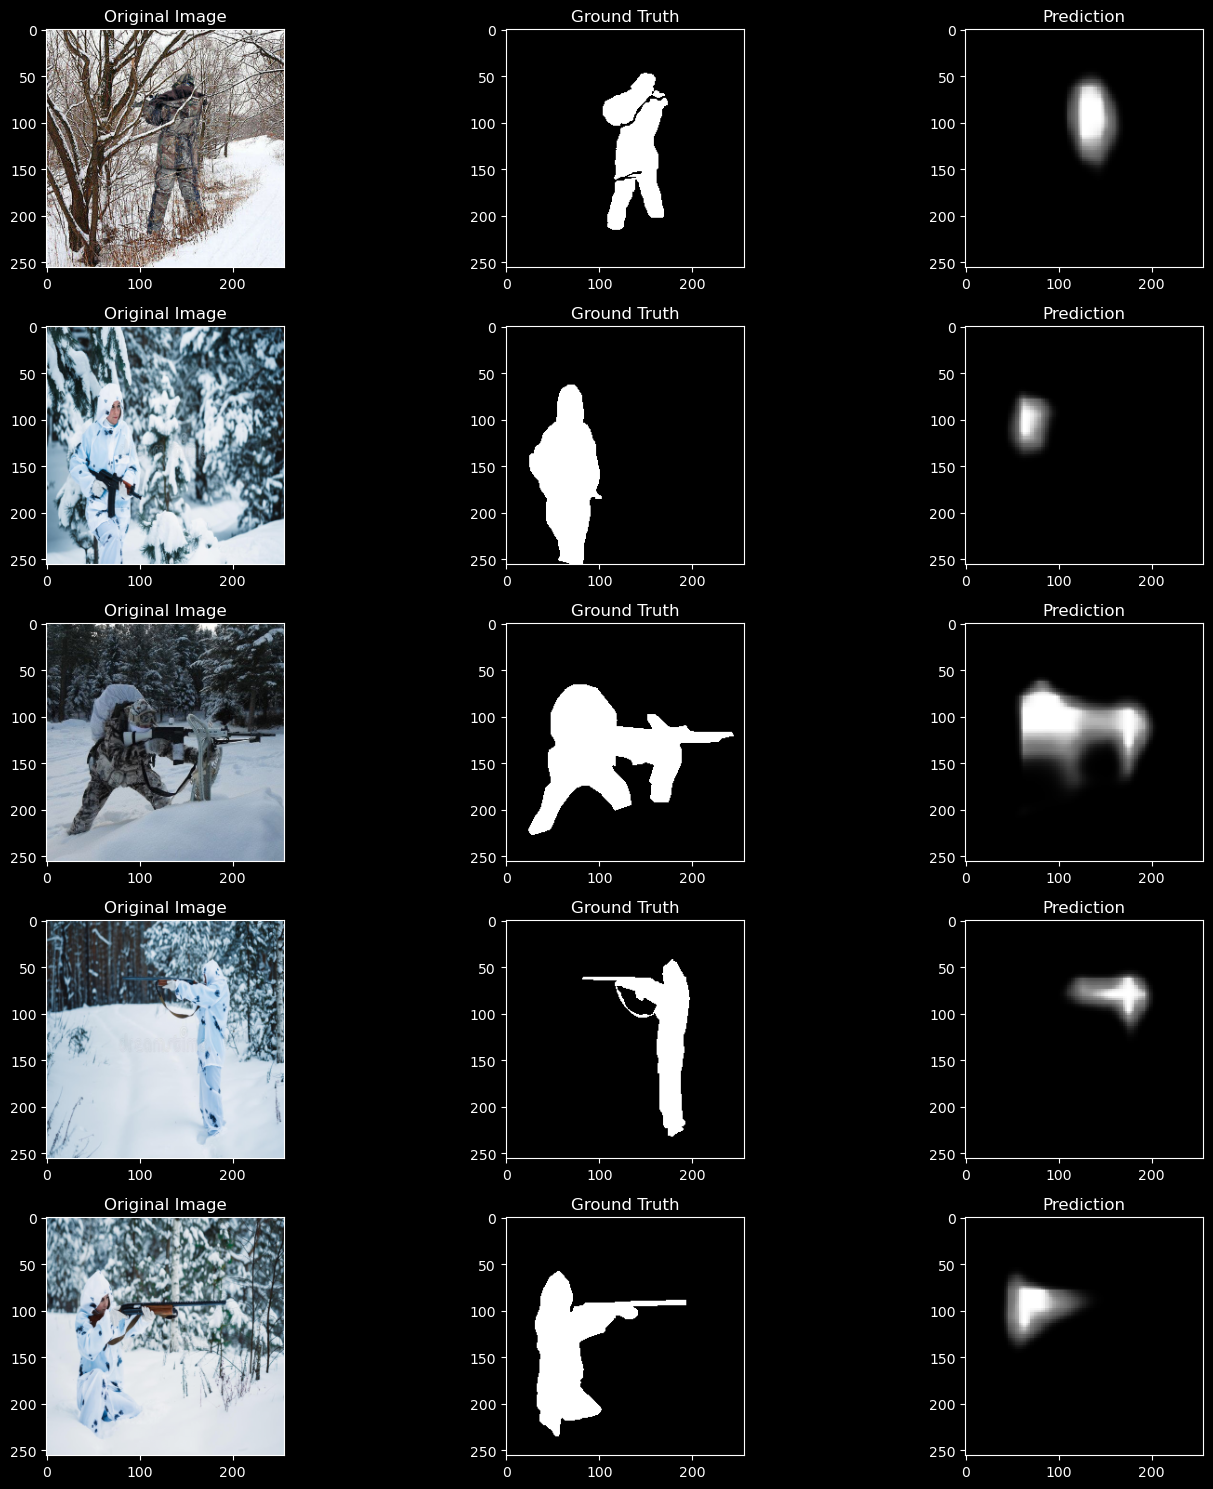

In [21]:
import matplotlib.pyplot as plt

# Predict on a subset of the test dataset
num_samples = 5
predictions = model.predict(np.array(test_images[:num_samples]))

# Display the test images, ground truth masks, and predicted masks
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 15))

for i in range(num_samples):
    axes[i, 0].imshow(test_images[i])
    axes[i, 0].set_title('Original Image')
    
    axes[i, 1].imshow(test_masks[i], cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    
    axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
    axes[i, 2].set_title('Prediction')

plt.tight_layout()
plt.show()


In [20]:
def compute_iou(y_true, y_pred):
    # Convert prediction to binary format based on a threshold (e.g., 0.5)
    y_pred = (y_pred > 0.5).astype(np.uint8)
    
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = intersection / union
    return iou

ious = [compute_iou(true_mask, pred_mask) for true_mask, pred_mask in zip(test_masks, predictions)]
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")


Mean IoU: -1.5664
